# **Complete Titanic tutorial with ML, NN & Ensembling**

### Hi Kagglers 👋👋👋,

### Welcome on this tutorial ! It is aimed for beginners but whatever your level you could read it, and if you find a way to improve it I encourage you to fork this notebook and contribute by adding a better solution !

![](https://i.ytimg.com/vi/yuMNWt6S0ZA/maxresdefault.jpg)

### In this notebook, we are going to predict wether a passenger of the famous boat will survive or not. By doing this, we will go through several topics and fundamental techniques of machine learning. Here is a list of these techniques and some additional resources that you can consult to find out more: 

[EDA | Data exploration](https://medium.com/python-pandemonium/introduction-to-exploratory-data-analysis-in-python-8b6bcb55c190)  
[Features engineering](https://adataanalyst.com/machine-learning/comprehensive-guide-feature-engineering/)  
[Evaluating a model over one training | metrics](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)  
[Evaluating a model over several trainings | k-fold cross validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)  
[Neural network with keras](https://elitedatascience.com/keras-tutorial-deep-learning-in-python)  
[Ensembling](https://mlwave.com/kaggle-ensembling-guide/)

## **Table of Contents**

1. [Data exploration](#data_exploration)
2. [Feature egineering](#fe)
3. [Try several models](#trymodels)
4. [Choosing the best model](#choose)
5. [Esembling - Homemade classifier](#ensembling)
6. [Submission](#submission)
7. [Results](#results)  


## **Imports and useful functions**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib
import pydot
import re
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.exceptions import NotFittedError
from sklearn.base import BaseEstimator, ClassifierMixin

from IPython.display import display

Using TensorFlow backend.


In [2]:
# Some useful functions we'll use in this notebook
def display_confusion_matrix(target, prediction, score=None):
    cm = metrics.confusion_matrix(target, prediction)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        score_title = 'Accuracy Score: {0}'.format(round(score, 5))
        plt.title(score_title, size = 14)
    classification_report = pd.DataFrame.from_dict(metrics.classification_report(target, prediction, output_dict=True), orient='index')
    display(classification_report.round(2))
    
def visualize_tree(tree, feature_names):
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f, feature_names=feature_names)
    try:
        subprocess.check_call(["dot", "-Tpng", "dt.dot", "-o", "dt.png"])
    except:
        exit("Could not run dot, ie graphviz, to produce visualization")
        
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [3]:
# Path of datasets
path_train = '../input/train.csv'
path_test = '../input/test.csv'

## **1. Data exploration** <a name="data_exploration"></a>

In [4]:
# Create dataframe for training dataset and print five first rows as preview
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Compute some basical statistics on the dataset
train_df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
draw_missing_data_table(train_df_raw)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


### There is 77% of missing data in the cabin column, it's usually way too much for this column to be exploitable, but as we have a small amount of data, we will still try to use it in feature engineering. 
### For the age, we will either interpolate missing values or we will fill it with the mean for the corresponding category (in term of class, age, sex) of passenger. There is only two missing values for the embarked column, let's try to replace it. Below is the distribution of Embarked according to Fare and sex. Let's look a the two passengers with missing embarked value and choose the best matching embarked value according to their fare value and sex !

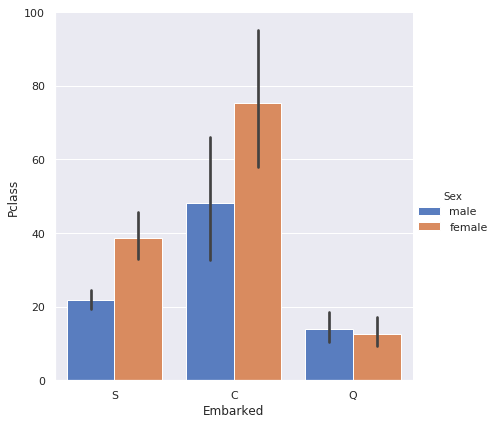

In [8]:
plot = sns.catplot(x="Embarked", y="Fare", hue="Sex", data=train_df_raw,
                height=6, kind="bar", palette="muted")
plot.set_ylabels("Pclass")
plt.show()

In [9]:
train_df_raw[train_df_raw['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


### Both passengers are female who paid 80 dollars as fare for their tickets, so the more probable embarked value for them is Cherbourg (C). We'll replace those missing values later in feature engineering.

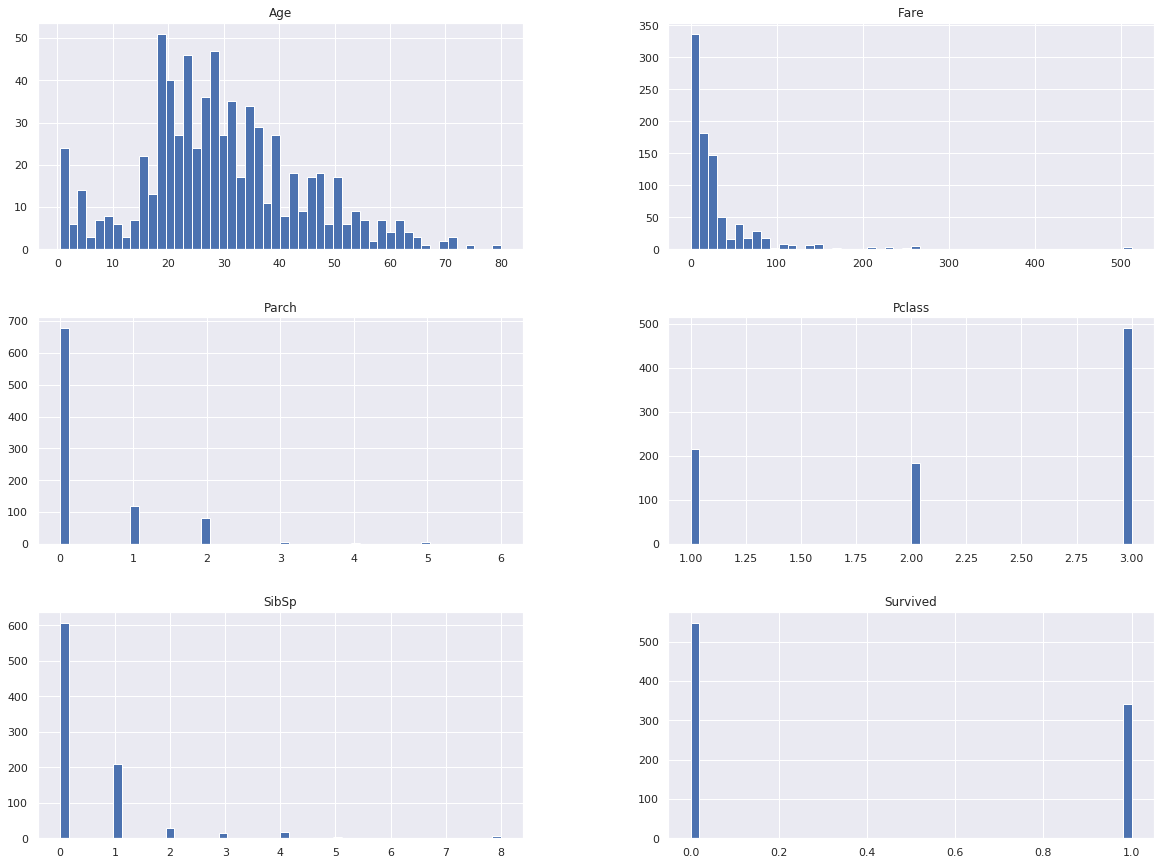

In [10]:
# Let's plot some histograms to have a previzualisation of some of the data ...
train_df_raw.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

### With this first exploration, we can see that :

* Only aproximately 35% of passengers survived ...
* More than the half of passengers are in the lowest class (pclass = 3)
* Most of the fare tickets are below 50
* Majority of passengers are alone (sibsp and parch)

## **2. Features engineering** <a name="fe"></a>

### My advice is to group all the transformations to be done on the dataset in a single function. This way, you can apply the same changes to the training dataset and the test dataset easily. Moreover, if you want to add a modification, you'll have to do it only in the function!

In [11]:
def preprocess_data(df):
    
    processed_df = df
        
    ########## Deal with missing values ##########
    
    # As we saw before, the two missing values for embarked columns can be replaced by 'C' (Cherbourg)
    processed_df['Embarked'].fillna('C', inplace=True)
    
    # We replace missing ages by the mean age of passengers who belong to the same group of class/sex/family
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex','Parch','SibSp'])['Age'].transform(lambda x: x.fillna(x.mean()))
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex','Parch'])['Age'].transform(lambda x: x.fillna(x.mean()))
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
    
    # We replace the only missing fare value for test dataset and the missing values of the cabin column
    processed_df['Fare'] = processed_df['Fare'].interpolate()
    processed_df['Cabin'].fillna('U', inplace=True)
    
    ########## Feature engineering on columns ##########
    
    # Create a Title column from name column
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in train_df_raw['Name']), index=train_df_raw.index)
    processed_df['Title'] = processed_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    processed_df['Title'] = processed_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')
    processed_df['Title'] = processed_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
    
    # Filling Age missing values with mean age of passengers who have the same title
    processed_df['Age'] = processed_df.groupby(['Title'])['Age'].transform(lambda x: x.fillna(x.mean()))

    # Transform categorical variables to numeric variables
    processed_df['Sex'] = processed_df['Sex'].map({'male': 0, 'female': 1})
    processed_df['Embarked'] = processed_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # Create a Family Size, Is Alone, Child and Mother columns
    processed_df['FamillySize'] = processed_df['SibSp'] + processed_df['Parch'] + 1
    processed_df['FamillySize'][processed_df['FamillySize'].between(1, 5, inclusive=False)] = 2
    processed_df['FamillySize'][processed_df['FamillySize']>5] = 3
    processed_df['IsAlone'] = np.where(processed_df['FamillySize']!=1, 0, 1)
    processed_df['IsChild'] = processed_df['Age'] < 18
    processed_df['IsChild'] = processed_df['IsChild'].astype(int)
    
    # Modification of cabin column to keep only the letter contained corresponding to the deck of the boat
    processed_df['Cabin'] = processed_df['Cabin'].str[:1]
    processed_df['Cabin'] = processed_df['Cabin'].map({cabin: p for p, cabin in enumerate(set(cab for cab in processed_df['Cabin']))})
    
    # Create a ticket survivor column which is set to 1 if an other passenger with the same ticket survived and 0 else
    # Note : this implementation is ugly and unefficient, if sombody found a way to do it easily with pandas (it must be a way), please comment the kernel with your solution !
    processed_df['TicketSurvivor'] = pd.Series(0, index=processed_df.index)
    tickets = processed_df['Ticket'].value_counts().to_dict()
    for t, occ in tickets.items():
        if occ != 1:
            table = train_df_raw['Survived'][train_df_raw['Ticket'] == t]
            if sum(table) != 0:
                processed_df['TicketSurvivor'][processed_df['Ticket'] == t] = 1
    
    # These two columns are not useful anymore
    processed_df = processed_df.drop(['Name', 'Ticket', 'PassengerId'], 1)    
    
    return processed_df

In [12]:
# Let's divide the train dataset in two datasets to evaluate perfomance of the machine learning models we'll use
train_df = train_df_raw.copy()
X = train_df.drop(['Survived'], 1)
Y = train_df['Survived']

X = preprocess_data(X)
# We scale our data, it is essential for a smooth working of the models. Scaling means that each columns as a 0 mean and a 1 variance
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)
    
# Split dataset for model testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamillySize,IsAlone,IsChild,TicketSurvivor
331,-1.566107,-0.737695,1.181540,-0.474545,-0.473674,-0.074583,-2.644517,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
733,-0.369365,-0.737695,-0.483367,-0.474545,-0.473674,-0.386671,0.439599,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
382,0.827377,-0.737695,0.182596,-0.474545,-0.473674,-0.488854,0.439599,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
704,0.827377,-0.737695,-0.261380,0.432793,-0.473674,-0.490280,0.439599,-0.571933,-0.707550,0.668886,-1.231645,-0.405840,-0.596795
813,0.827377,1.355574,-1.741297,3.154809,2.008933,-0.018709,0.439599,-0.571933,0.263832,2.008162,-1.231645,2.464027,-0.596795


## **3. Try several models** <a name="trymodels"></a>

### **Introduction to metrics**

### To evaluate our models on the test set for this classification problem, we are going to use several metrics, which will be displayed into a confusion matrix (to easily see the false positive and the false negative predicted by the model, i.e. respectivey type I & II errors). From those two types of error, some metrics can be computed : the F1 score, the Recall, the accuracy. You can find on the image below a quick summary of what is a confusion matrix, how to read it and what are those metrics:

![](https://image.slidesharecdn.com/qconrio-machinelearningforeveryone-150826200704-lva1-app6892/95/qcon-rio-machine-learning-for-everyone-51-638.jpg?cb=1440698161)

### **3.1 Logistic regression**

### Logistic regression is the "hello world" of machine learning algorithms. It is very simple to understand how it works, [here](https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102) is a good article which cover theory of this algorithm.

,precision,recall,f1-score,support
0,0.84,0.86,0.85,105
1,0.79,0.77,0.78,74
macro avg,0.82,0.81,0.81,179
micro avg,0.82,0.82,0.82,179
weighted avg,0.82,0.82,0.82,179


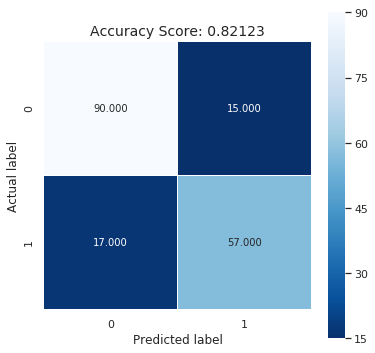

In [13]:
# Create and train model on train data sample
lg = LogisticRegression(solver='lbfgs', random_state=42)
lg.fit(X_train, Y_train)

# Predict for test data sample
logistic_prediction = lg.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, logistic_prediction)
display_confusion_matrix(Y_test, logistic_prediction, score=score)

### **3.2 Decision tree**

### Decision tree is a quite intuitive model, easy to vizualize and interpret. Here, we are even going to display our tree to improve our understanding on how the algorithm manage to classify our samples:

### To find out more about decision trees: [DT](https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248)


,precision,recall,f1-score,support
0,0.85,0.90,0.87,105
1,0.84,0.78,0.81,74
macro avg,0.85,0.84,0.84,179
micro avg,0.85,0.85,0.85,179
weighted avg,0.85,0.85,0.85,179


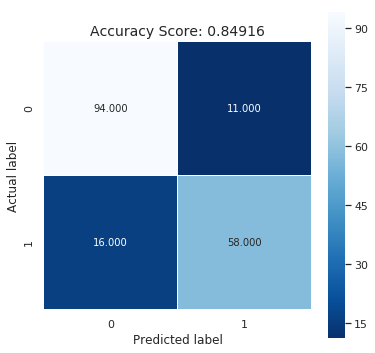

In [14]:
dt = DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=20, random_state=42)
dt.fit(X_train, Y_train)
dt_prediction = dt.predict(X_test)

score = metrics.accuracy_score(Y_test, dt_prediction)
display_confusion_matrix(Y_test, dt_prediction, score=score)

In [15]:
visualize_tree(dt, X_test.columns)
! dot -Tpng dt.dot > dt.png

![title](dt.png)

### **3.3 SVM**

### SVMs aim at solving classification problems by finding good decision boundaries between two sets of points belonging to two different categories. To understand how it works, you can refer to [this webpage](https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/).

,precision,recall,f1-score,support
0,0.83,0.92,0.87,105
1,0.87,0.73,0.79,74
macro avg,0.85,0.83,0.83,179
micro avg,0.84,0.84,0.84,179
weighted avg,0.85,0.84,0.84,179


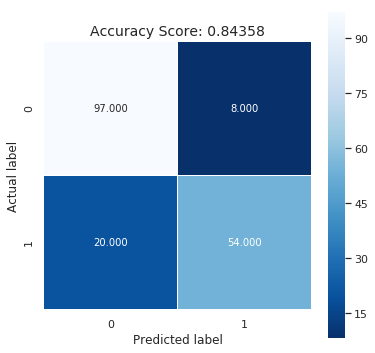

In [16]:
svm = SVC(gamma='auto', random_state=42)
svm.fit(X_train, Y_train)
svm_prediction = svm.predict(X_test)

score = metrics.accuracy_score(Y_test, svm_prediction)
display_confusion_matrix(Y_test, svm_prediction, score=score)

### **3.4 Random forest**

### Random forest is a robust & practical algorithm based on decision trees. It outperforms almost always the two previous algorithm we saw. If you want to find out more about this model, [here](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d) is a good start.

,precision,recall,f1-score,support
0,0.85,0.90,0.87,105
1,0.84,0.78,0.81,74
macro avg,0.85,0.84,0.84,179
micro avg,0.85,0.85,0.85,179
weighted avg,0.85,0.85,0.85,179


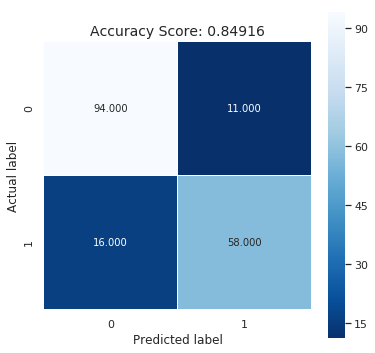

In [17]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, Y_train)
rf_prediction = rf.predict(X_test)

score = metrics.accuracy_score(Y_test, rf_prediction)
display_confusion_matrix(Y_test, rf_prediction, score=score)

### **3.5 Artificial neural network**

### Neural networks are deep learning models which are based on the imitation of the human brain. To build a neural network, we are going to use Keras. Keras is a high level API for tensorflow, which is a tensor-manipulation framework made by google. Keras allows you to build neural networks by assembling blocks (which are the layers of our neural network). For more details, [here](https://elitedatascience.com/keras-tutorial-deep-learning-in-python) is a great keras tutorial. 

In [18]:
def build_ann(optimizer='adam'):
    
    # Initializing our ANN
    ann = Sequential()
    
    # Adding the input layer and the first hidden layer of our ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(13,)))
    
    # Add other layers, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # Compiling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [19]:
opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)
# Training the ANN
history = ann.fit(X_train, Y_train, batch_size=16, epochs=30, validation_data=(X_test, Y_test))

Train on 712 samples, validate on 179 samples
Epoch 1/30
712/712 [==============================] - 1s 1ms/step - loss: 0.6822 - acc: 0.6222 - val_loss: 0.5872 - val_acc: 0.7095
Epoch 2/30
712/712 [==============================] - 0s 104us/step - loss: 0.5555 - acc: 0.7346 - val_loss: 0.4982 - val_acc: 0.7765
Epoch 3/30
712/712 [==============================] - 0s 103us/step - loss: 0.4986 - acc: 0.7823 - val_loss: 0.4473 - val_acc: 0.8156
Epoch 4/30
712/712 [==============================] - 0s 100us/step - loss: 0.4677 - acc: 0.8006 - val_loss: 0.4139 - val_acc: 0.8268
Epoch 5/30
712/712 [==============================] - 0s 101us/step - loss: 0.4526 - acc: 0.8287 - val_loss: 0.3929 - val_acc: 0.8324
Epoch 6/30
712/712 [==============================] - 0s 112us/step - loss: 0.4427 - acc: 0.8174 - val_loss: 0.3829 - val_acc: 0.8324
Epoch 7/30
712/712 [==============================] - 0s 106us/step - loss: 0.4161 - acc: 0.8315 - val_loss: 0.3727 - val_acc: 0.8436
Epoch 8/30
712/712

,precision,recall,f1-score,support
0,0.85,0.92,0.89,105
1,0.88,0.77,0.82,74
macro avg,0.86,0.85,0.85,179
micro avg,0.86,0.86,0.86,179
weighted avg,0.86,0.86,0.86,179


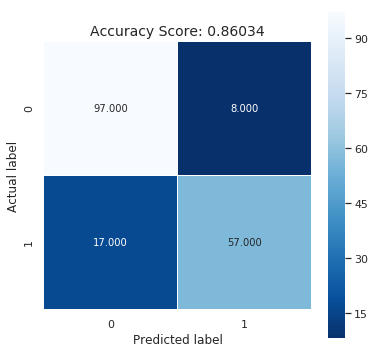

In [20]:
# Predicting the Test set results
ann_prediction = ann.predict(X_test)
ann_prediction = (ann_prediction > 0.5) # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, ann_prediction)
display_confusion_matrix(Y_test, ann_prediction, score=score)

## **4. Finding the best model using k-folds cross validation** <a name="choose"></a>

### The precision we calculated above for those 4 different models does not mean anything. In fact, if we execute each cell again, we could have sightly different accuracy, because we trained again our models ! We need to verify which model has the best accuracy over several training steps ! We can do it using cross validation method, which consists of dividing out training set in k parts (folds) and evaluating k times using successively each part as the test set and the 9 other parts as the training set. Therefore, we can compute a mean error over the 10 trainings of our model:

![](https://www.researchgate.net/profile/Kiret_Dhindsa/publication/323969239/figure/fig10/AS:607404244873216@1521827865007/The-K-fold-cross-validation-scheme-133-Each-of-the-K-partitions-is-used-as-a-test.png)

### Let's check which one of our previously implemented model is the best one with this method. We will not only compute the mean but also the variance, because a good model needs to have the lowest possible variance in addition to have a low bias:

![](https://www.machinelearningtutorial.net/wp-content/uploads/2017/01/bias-variance-tradeoff.svg)

In [21]:
n_folds = 10
cv_score_lg = cross_val_score(estimator=lg, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_dt = cross_val_score(estimator=dt, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_svm = cross_val_score(estimator=svm, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_rf = cross_val_score(estimator=rf, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_ann = cross_val_score(estimator=KerasClassifier(build_fn=build_ann, batch_size=16, epochs=20, verbose=0),
                                 X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)

In [22]:
cv_result = {'lg': cv_score_lg, 'dt': cv_score_dt, 'svm': cv_score_svm, 'rf': cv_score_rf, 'ann': cv_score_ann}
cv_data = {model: [score.mean(), score.std()] for model, score in cv_result.items()}
cv_df = pd.DataFrame(cv_data, index=['Mean_accuracy', 'Variance'])
cv_df

,lg,dt,svm,rf,ann
Mean_accuracy,0.834380,0.834478,0.839896,0.807873,0.842664
Variance,0.057181,0.046082,0.053590,0.049253,0.045427


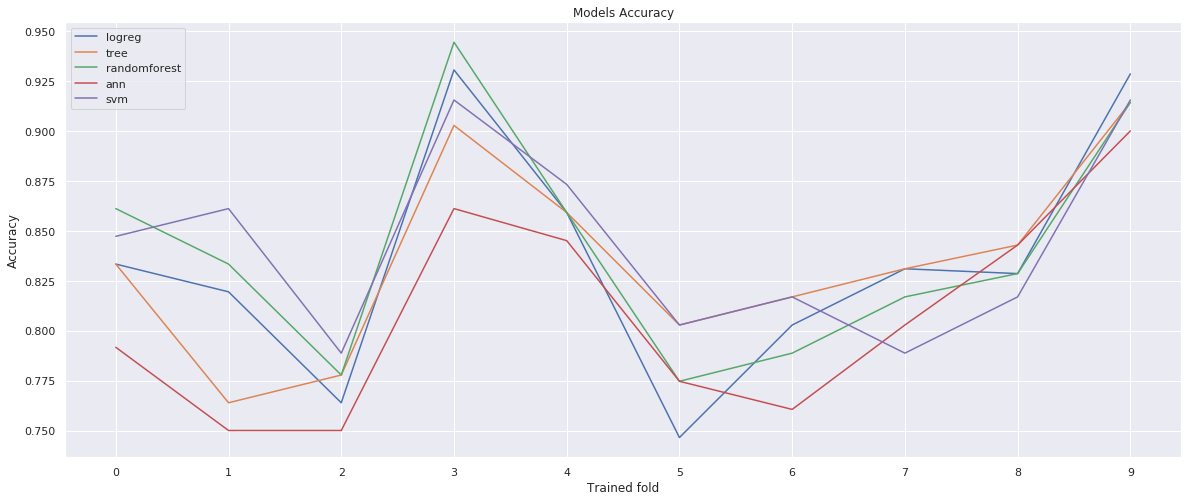

In [23]:
plt.figure(figsize=(20,8))
plt.plot(cv_result['lg'])
plt.plot(cv_result['dt'])
plt.plot(cv_result['svm'])
plt.plot(cv_result['rf'])
plt.plot(cv_result['ann'])
plt.title('Models Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Trained fold')
plt.xticks([k for k in range(n_folds)])
plt.legend(['logreg', 'tree', 'randomforest', 'ann', 'svm'], loc='upper left')
plt.show()

### All models seems to have a good accuracy and nearly the same variance, it seems that there is no "best model". Indeed, there is no one model which seems truly better than the other. In fact, if we make submissions with all of these models, we will obtain approximately the same score. Moreover, the variance is a little bit too high for saying that these models are reliable: 0.05 variance means that the same model can score 0.75 and 0.8, which is not very convenient.
### To obtain a better score, we will, in the next part, build our own classifier which will combine predictions from a random forest, an svm classifier and a keras neural networks. The diversity from these 3 very different models will increase the quality of our predictions and reduce the variance !

## **5. Ensembling: creating a homemade classifier** <a name="ensembling"></a>

### Ensembling is the science of combining classifiers to improve the accuracy of a models. Moreover, it diminushes the variance of our model making it more reliable. You can start learning about ensembling [here](https://towardsdatascience.com/two-is-better-than-one-ensembling-models-611ee4fa9bd8) !

### We are going to make our own scikit learn classifier. To do that, we'll create a class (inherited from scikit learn base classifiers classes) with three methods (fit / predict and score for the cross validation, just as the other classifiers we used from sckitlearn and keras). In the fit method, we just train our 3 classifiers on training data. In the predict method, we make a prediction with each of the 3 classifier and combine it : if two or more classifiers classified the passenger as a survivor, our homemade EsembleClassifier classify it as survivor. Else, it'll predict that the passenger did not survived.

In [24]:
class EsemblingClassifier:
    
    def __init__(self, verbose=True):
        self.ann = build_ann(optimizer=optimizers.Adam(lr=0.001))
        self.rf = RandomForestClassifier(n_estimators=300, max_depth=11, random_state=42)
        self.svm = SVC(random_state=42)
        self.trained = False
        self.verbose = verbose
        
    def fit(self, X, y):
        if self.verbose:
            print('-------- Fitting models --------')
        self.ann.fit(X, y, epochs=30, batch_size=16, verbose=0)
        self.rf.fit(X, y)
        self.svm.fit(X, y)
        self.trained = True
    
    def predict(self, X):
        if self.trained == False:
            raise NotFittedError('Please train the classifier before making a prediction')
        if self.verbose:
            print('-------- Making and combining predictions --------')
        predictions = list()
        pred_ann = self.ann.predict(X)
        pred_ann = (pred_ann > 0.5)*1
        pred_rf = self.rf.predict(X)
        pred_svm = self.svm.predict(X)
        for n in range(len(pred_ann)):
            combined = pred_ann[n] + pred_rf[n] + pred_svm[n]
            p = 0 if combined == 1 or combined == 0 else 1
            predictions.append(p)
        return predictions

-------- Fitting models --------
-------- Making and combining predictions --------


,precision,recall,f1-score,support
0,0.84,0.93,0.89,105
1,0.89,0.76,0.82,74
macro avg,0.87,0.85,0.85,179
micro avg,0.86,0.86,0.86,179
weighted avg,0.86,0.86,0.86,179


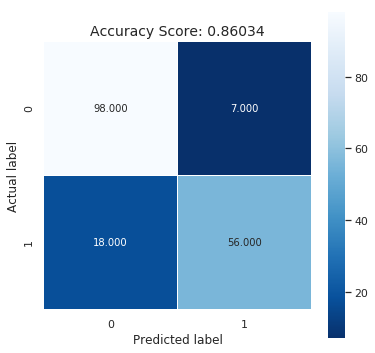

In [25]:
ens = EsemblingClassifier()
ens.fit(X_train, Y_train)
ens_prediction = ens.predict(X_test)
score = metrics.accuracy_score(Y_test, ens_prediction)
display_confusion_matrix(Y_test, ens_prediction, score=score)

### Our new model seems to be quite performing ! You can try to train and validate it several time on train_test_split, you'll see that the variance is not high so our model is also quite constant in its performances.
### Let's try this new model on the test dataset now !

## **6. Apply our homemade model on test dataset and submit on kaggle** <a name="submission"></a>

In [26]:
test_df_raw = pd.read_csv(path_test)
test = test_df_raw.copy()
test = preprocess_data(test)
test = pd.DataFrame(sc.fit_transform(test.values), index=test.index, columns=test.columns)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamillySize,IsAlone,IsChild,TicketSurvivor
0,0.873482,-0.755929,0.376278,-0.499470,-0.400248,-0.497185,0.433242,2.243165,-0.756787,-0.664957,0.807573,-0.347338,-0.3253
1,0.873482,1.322876,1.340981,0.616992,-0.400248,-0.512048,0.433242,-0.677841,1.245346,0.731787,-1.238278,-0.347338,-0.3253
2,-0.315819,-0.755929,2.498625,-0.499470,-0.400248,-0.463874,0.433242,2.243165,0.244279,-0.664957,0.807573,-0.347338,-0.3253
3,0.873482,-0.755929,-0.202543,-0.499470,-0.400248,-0.482248,0.433242,-0.677841,1.245346,-0.664957,0.807573,-0.347338,-0.3253
4,0.873482,1.322876,-0.588425,0.616992,0.619896,-0.417269,0.433242,-0.677841,-0.756787,0.731787,-1.238278,-0.347338,-0.3253


In [27]:
# Create and train model on train data sample
model_test = EsemblingClassifier()
model_test.fit(X, Y)

# Predict for test data sample
prediction = model_test.predict(test)

result_df = test_df_raw.copy()
result_df['Survived'] = prediction
result_df.to_csv('submission.csv', columns=['PassengerId', 'Survived'], index=False)

-------- Fitting models --------
-------- Making and combining predictions --------


In [28]:
result_df[['PassengerId', 'Survived']].head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## **7. Results** <a name="results"></a>

### We are not done yet ! What about the results ? I've tried to make 30 submissions with this classifier, here are the results :

#### - 2x 0.77511
#### - 4x 0.77990
#### - 10x 0.78468
#### - 11x 0.78947
#### - 2x 0.79425
#### - 1x 0.79904

### Although I know that we can do much better, the 0.79904 still places us in the top 16%. On the other hand, we see that our homemade classifier has reduced the variance so it is reliable and constant in its performance (something that is not tested by the leaderboard but still important for a data sceintist). Moreover, our solution remains simple and accessible even for beginners. 

### Thank you for your reading, feel free to fork this kernel and improve it, and enjoy datascience :D

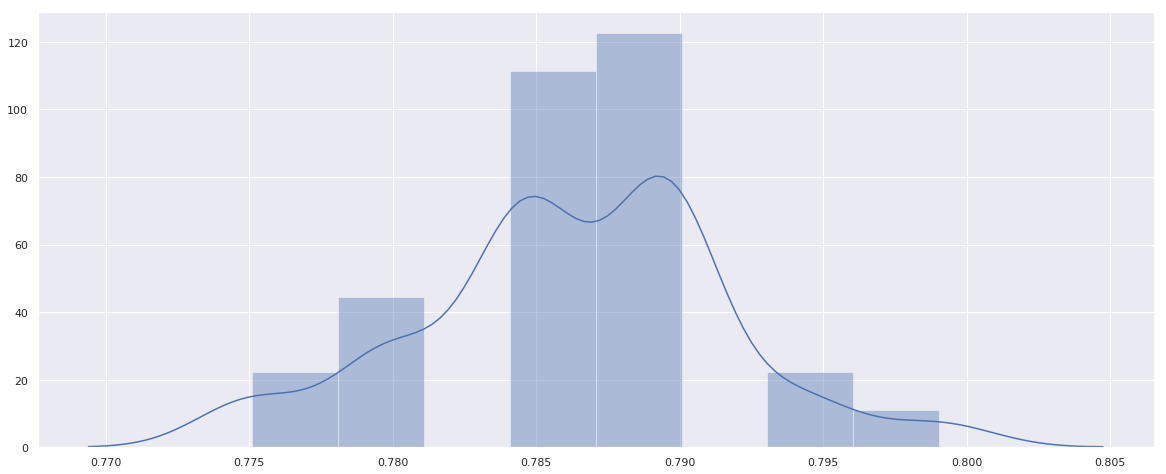

In [29]:
import scipy.stats as stats

plt.figure(figsize=(20, 8))
sub = 2*[0.77511] + 4*[0.77990] + 10*[0.78468] + 11*[0.78947] + 2*[0.79425] + 1*[0.79904]
sns.distplot(sub)
plt.show()

*Check out this beautiful distribution of kaggle scoring for our homemade classifier !*